In [1]:
import astropy
import numpy as np
import splinv
import matplotlib.pyplot as plt
%matplotlib inline
splinv.hmod_v2
from scipy.integrate import quad
import os
import h5py

In [2]:
from splinv.default import *
from astropy import units
from splinv.grid import Cartesian
from configparser import ConfigParser
from splinv import hmod

In [3]:
rho_unt = units.solMass/units.Mpc**3
z_h     =   0.1
log_m   =   15.6
M_200   =   10.**(log_m)
conc    =   2.#6.02*(M_200/1.E13)**(-0.12)*(1.47/(1.+z_h))**(0.16)
halo    =  splinv.hmod.nfwTJ03(mass=M_200,conc=conc,redshift=z_h,ra=0.,dec=0.)
configName  =   'config_halolet.ini'
parser      =   ConfigParser()
parser.read(configName)

['config_halolet.ini']

In [4]:
# this is rs in units of arcmin
print(halo.rs_arcsec/60.)
# you need to setup a grid that with pixel scale (at least) smaller than the scale of halo
# and ensure that the stamp size is not too big
parser.set('transPlane','xmin','-32.5') # in units of arcmins 
parser.set('transPlane','ymin','-32.5') 
parser.set('transPlane','nx','64') 
parser.set('transPlane','ny','64') 

19.63754552157469


In [5]:
Grid    =   Cartesian(parser)
lensKer1=   Grid.lensing_kernel(deltaIn=False)
L       =   Grid.nx*Grid.scale
modelDict=  hmod.nfwShearlet2D(parser,lensKer1)

xx=np.fft.fftshift(np.fft.fftfreq(Grid.nx,1./Grid.nx))
yy=np.fft.fftshift(np.fft.fftfreq(Grid.ny,1./Grid.ny))
XX,YY=np.meshgrid(xx,yy)

In [6]:
nsamp   =   10000 # use only 10000 galaxies since the code is slow
ra      =   np.random.rand(nsamp)*L-L/2. 
dec     =   np.random.rand(nsamp)*L-L/2.
redshift=   np.ones(nsamp)*0.1
sigma   =   halo.Sigma(ra*3600.,dec*3600.)
dsigma  =   halo.DeltaSigmaComplex(ra*3600.,dec*3600.)

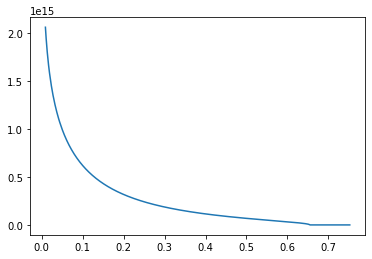

In [7]:
r=np.sqrt(ra**2.+dec**2.)
inds=np.argsort(r)
_=plt.plot(r[inds],sigma[inds])

In [8]:
sigmaPix=  Grid.pixelize_data(ra,dec,redshift,sigma,\
               method='FFT')[0]
dsig1Pix=  Grid.pixelize_data(ra,dec,redshift,dsigma.real,\
               method='FFT')[0]
dsig2Pix=  Grid.pixelize_data(ra,dec,redshift,dsigma.imag,\
               method='FFT')[0]


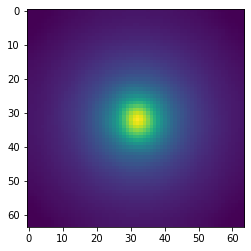

In [9]:
plt.imshow(sigmaPix)

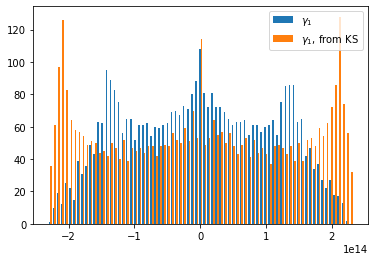

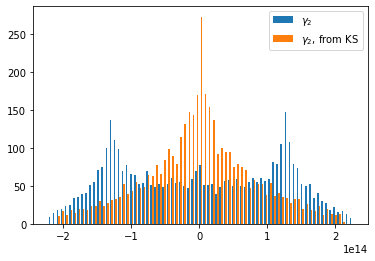

In [10]:
ks_gamma = modelDict.ks2D.transform(sigmaPix, inFou=False, outFou=False)
plt.hist([dsig1Pix.ravel(), ks_gamma.real.ravel()], 75, label=[r'$\gamma_1$', r'$\gamma_1$, from KS'])
plt.legend(loc='upper right')
plt.show()

plt.hist([dsig2Pix.ravel(), ks_gamma.imag.ravel()], 75, label=[r'$\gamma_{2}}$', r'$\gamma_{2}$, from KS'])
plt.legend(loc='upper right')
plt.show()

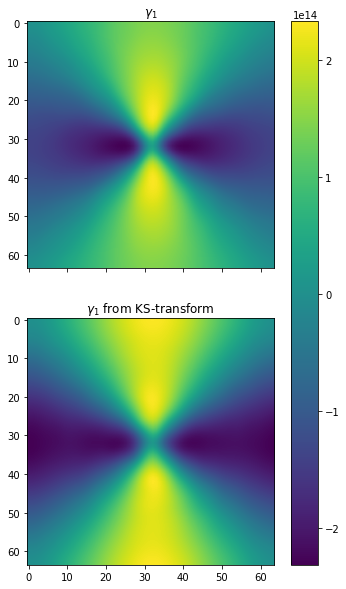

In [11]:
interp = 'bilinear'
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(6, 10))
axs[0].set_title(r'$\gamma_1$')
dsig2plot = axs[0].imshow(dsig1Pix, interpolation=interp)
axs[1].set_title(r'$\gamma_1$ from KS-transform')
ks_gamma1_plot = axs[1].imshow(ks_gamma.real, interpolation=interp)
fig.colorbar(ks_gamma1_plot, ax=axs.ravel().tolist())
plt.show()